## Packages

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colorbar import ColorbarBase
import matplotlib.patches as mpatches

## Validation Loss

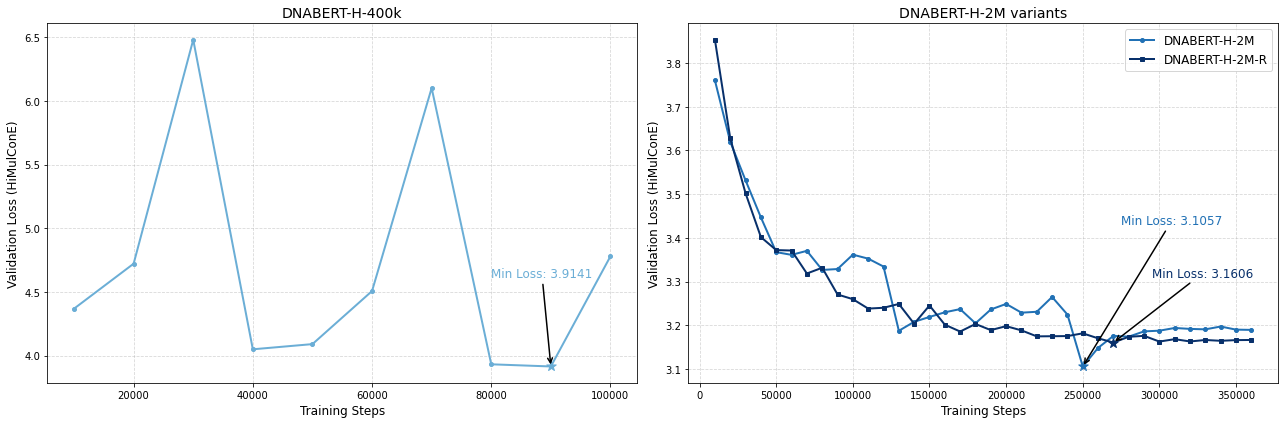

In [870]:
# Read CSV files
v0 = pd.read_csv('400k.csv')
v1 = pd.read_csv('ver1.csv')
v2 = pd.read_csv('ver2.csv')

# Create a figure with 1x2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Colors - using more visually distinct colors
colors = {
    'v0': '#6baed6',  # Blue
    'v1': '#2171b5',  # Green
    'v2': '#08306b'   # Red
}

# First subplot - DNABERT-H-2M (400k) validation loss
ax1.plot(v0['Step'], v0['Value'], color=colors['v0'], linestyle='-', 
         marker='o', linewidth=2, markersize=4)

# Grid style and labels for first subplot
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.set_xlabel('Training Steps', fontsize=12)
ax1.set_ylabel('Validation Loss (HiMulConE)', fontsize=12)
ax1.set_title('DNABERT-H-400k', fontsize=14)

# Min values calculation for first subplot
min_v0_idx = v0['Value'].idxmin()
min_v0_loss = v0.loc[min_v0_idx, 'Value']
min_v0_step = v0.loc[min_v0_idx, 'Step']

# Highlight minimum point for first subplot
ax1.scatter(min_v0_step, min_v0_loss, color=colors['v0'], s=100, marker='*')
ax1.annotate(f'Min Loss: {min_v0_loss:.4f}', 
             xy=(min_v0_step, min_v0_loss),
             xytext=(min_v0_step - 10000, min_v0_loss + 0.7),
             arrowprops=dict(facecolor=colors['v0'], arrowstyle='->', linewidth=1.5),
             fontsize=12, color=colors['v0'])

# Second subplot - Comparison between DNABERT-H-2M and DNABERT-H-2M-R
ax2.plot(v1['Step'], v1['Value'], color=colors['v1'], linestyle='-', 
         marker='o', linewidth=2, markersize=4, label='DNABERT-H-2M')
ax2.plot(v2['Step'], v2['Value'], color=colors['v2'], linestyle='-', 
         marker='s', linewidth=2, markersize=4, label='DNABERT-H-2M-R')

# Grid style and labels for second subplot
ax2.grid(True, linestyle='--', alpha=0.5)
ax2.set_xlabel('Training Steps', fontsize=12)
ax2.set_ylabel('Validation Loss (HiMulConE)', fontsize=12)
ax2.set_title('DNABERT-H-2M variants', fontsize=14)
ax2.legend(fontsize=12)

# Min values calculation for second subplot
min_v1_idx = v1['Value'].idxmin()
min_v2_idx = v2['Value'].idxmin()

min_v1_loss = v1.loc[min_v1_idx, 'Value']
min_v1_step = v1.loc[min_v1_idx, 'Step']

min_v2_loss = v2.loc[min_v2_idx, 'Value']
min_v2_step = v2.loc[min_v2_idx, 'Step']

# Highlight minimum points for second subplot
ax2.scatter(min_v1_step, min_v1_loss, color=colors['v1'], s=100, marker='*')
ax2.scatter(min_v2_step, min_v2_loss, color=colors['v2'], s=100, marker='*')

# Annotations for second subplot
ax2.annotate(f'Min Loss: {min_v1_loss:.4f}', 
             xy=(min_v1_step, min_v1_loss),
             xytext=(min_v1_step + 25000, min_v1_loss + 0.325),
             arrowprops=dict(facecolor=colors['v1'], arrowstyle='->', linewidth=1.5),
             fontsize=12, color=colors['v1'])

ax2.annotate(f'Min Loss: {min_v2_loss:.4f}', 
             xy=(min_v2_step, min_v2_loss),
             xytext=(min_v2_step + 25000, min_v2_loss + 0.15),
             arrowprops=dict(facecolor=colors['v2'], arrowstyle='->', linewidth=1.5),
             fontsize=12, color=colors['v2'])

# Adjust layout and save
plt.tight_layout()
plt.savefig('figs/combined_validation_loss.svg', dpi=300)
plt.show()

## Batch Composition

In [871]:
from tqdm import tqdm

def count_unique_values_in_chunks(df, chunk_size=9):
    # Select columns 4 through 11 (Python uses 0-based indexing)
    selected_columns = df.columns[3:11]
    
    # Initialize a list to store unique value counts for each chunk
    unique_ratio_list = []
    anchor_list= []
    count_list = []
    
    unique_sk = []
    
    # Use tqdm to wrap the iteration and show progress
    for i in tqdm(range(0, len(df), chunk_size), desc="Processing Chunks"):
        # Select the current chunk
        chunk = df.iloc[i:i+chunk_size]
        anchor = chunk['Superkingdom'].iloc[0]
        count = len(chunk[chunk['Superkingdom']==anchor])
        anchor_list.append(anchor)
        
        # Count unique values only for selected columns
        unique_counts = chunk[chunk['Superkingdom']==anchor][selected_columns].nunique().tolist()
        unique_ratio = [uc/count for uc in unique_counts]
        
        # Append the unique counts for this chunk to the list
        unique_ratio_list.append(unique_ratio)
        unique_sk.append(chunk['Superkingdom'].value_counts().to_dict())
        count_list.append(count)
    
    return unique_ratio_list, unique_sk, anchor_list, count_list

def process_superkingdom_batches(unique_sk, anchor_list, batch_size=1000):
    # List to store statistics for each batch
    batch_stats = []
    
    # Batch processing
    for start in tqdm(range(0, len(unique_sk), batch_size), desc="Processing Batches"):
        batch_sk = unique_sk[start:start+batch_size]
        batch_anchors = anchor_list[start:start+batch_size]
        
        # Statistics for each Superkingdom in the batch
        batch_summary = {}
        
        # Get unique Superkingdoms
        unique_superkingdoms = set(batch_anchors)
        
        for sk in unique_superkingdoms:
            # Filter data for this Superkingdom
            sk_indices = [i for i, anchor in enumerate(batch_anchors) if anchor == sk]
            sk_data = [batch_sk[i] for i in sk_indices]
            
            # Aggregate by Superkingdom
            sk_summary = {
                'superkingdom': sk,
                'total_count': len(sk_indices),
                'distribution': {}
            }
            
            # Calculate distribution
            distribution = {}
            for item_dict in sk_data:
                for key, value in item_dict.items():
                    distribution[key] = distribution.get(key, 0) + value
            
            # Normalize
            total = sum(distribution.values())
            sk_summary['distribution'] = {
                k: v/total for k, v in distribution.items()
            }
            
            # Add top 5 distribution
            sorted_dist = sorted(sk_summary['distribution'].items(), key=lambda x: x[1], reverse=True)[:5]
            sk_summary['top_5_distribution'] = dict(sorted_dist)

            del sk_summary['distribution']
            
            batch_summary[sk] = sk_summary
        
        batch_stats.append(batch_summary)
    
    return batch_stats

In [986]:
def plot_superkingdom_distribution(batch_stats, output_filename=None):
    """
    Plot the distribution of superkingdoms across batches in a 1x3 subplot layout
    with a unified legend for all subplots.
    
    Parameters:
    -----------
    batch_stats : list
        List of dictionaries containing batch statistics
    output_filename : str, optional
        If provided, the plot will be saved to this filename in SVG format
    
    Returns:
    --------
    matplotlib.figure.Figure
        The created figure object
    """
    # Prepare for data formatting
    plot_data = {}
    all_keys = set()  # Set to collect all keys
    
    # Collect distribution data for each Superkingdom
    for batch_num, batch in enumerate(batch_stats):
        for sk, sk_summary in batch.items():
            if sk not in plot_data:
                plot_data[sk] = {}
            
            # Store distribution for each batch
            for key, value in sk_summary['top_5_distribution'].items():
                if key not in plot_data[sk]:
                    plot_data[sk][key] = []
                plot_data[sk][key].append(value)
                all_keys.add(key)  # Add key
    
    # Create plot
    fig = plt.figure(figsize=(18, 6))
    
    # Create a 1x4 GridSpec with specified width ratios
    gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.2])
    
    # Superkingdoms to plot
    superkingdoms = [2, 2759, 10239]
    
    # Set image color for each Superkingdom
    color_map = {
        2: '#4DB6AC',     # Bacteria - Teal green (Material Design Teal)
        2759: '#8D6E63',  # Fungi - Soft brown (Material Design Brown)
        10239: '#E57373'  # Virus - Coral red (Material Design Red)
    }
    
    # Clear titles for subplots
    superkingdom_names = {
        2: 'Bacteria',
        2759: 'Fungi',
        10239: 'Virus'
    }
    
    # Handles and labels for legend
    legend_handles = []
    legend_labels = []
    
    # Create up to 3 subplots
    for i in range(min(3, len(superkingdoms))):
        sk = superkingdoms[i]
        distributions = plot_data[sk]
        
        ax = fig.add_subplot(gs[0, i])
        
        # Plot time series for each key
        for key, values in distributions.items():
            line, = ax.plot(range(len(values)), values, label=key, marker='o', 
                           color=color_map[key], linewidth=2)
            
            # Collect handles and labels for legend only for the first subplot
            if i == 0:
                legend_handles.append(line)
                legend_labels.append(superkingdom_names[key])
        
        # Use Superkingdom name as title
        ax.set_title(superkingdom_names[sk], fontsize=20)

        # Customize X-axis ticks
        tick_interval = max(1, 241 // 5)
        ticks = range(0, 241, tick_interval)
        ax.set_xticks(ticks)
        ax.set_xticklabels([f'{(i)}k' if i > 0 else '0' for i in range(0, 241, tick_interval)], rotation=45, ha='right')
        
        ax.set_xlabel('Batch Number (k)', fontsize=12)
        ax.set_ylabel('Normalized Proportion', fontsize=12)
        
        # Add grid lines
        ax.grid(True, linestyle='--', alpha=0.7)
        
        # Standardize Y-axis range to 0-1
        ax.set_ylim(0, 1)
        
        # Make X and Y axis ticks bold
        ax.tick_params(axis='both', which='major', labelsize=10, width=1.5)
    
    # Place legend in the 4th grid position
    legend_ax = fig.add_subplot(gs[0, 3])
    legend_ax.axis('off')
    
    # Create unified legend
    legend = legend_ax.legend(legend_handles, legend_labels, 
                             loc='center right', 
                             title='Group', 
                             fontsize=16,
                             frameon=False)
    legend.get_title().set_fontsize(16)
    
    # Adjust space between subplots
    plt.tight_layout()
    
    # Save as SVG file if specified
    if output_filename:
        # Add .svg extension if not specified
        if not output_filename.lower().endswith('.svg'):
            output_filename += '.svg'
        plt.savefig(output_filename, format='svg', bbox_inches='tight', dpi=300)
        print(f"Plot saved as {output_filename}")
    
    return fig

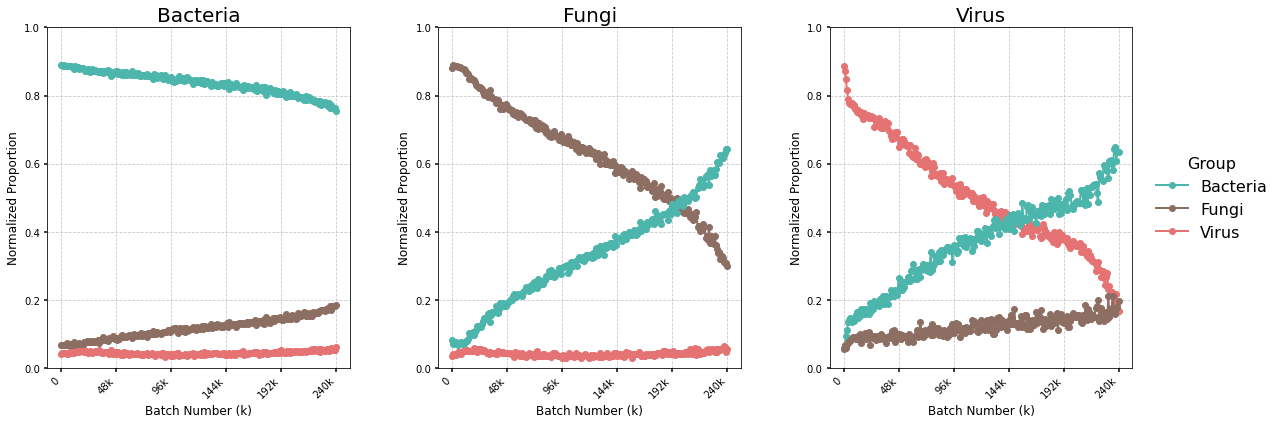

In [988]:
# Load df and indices
df = pd.read_csv('2m_stats.tsv', sep='\t')
indices = np.load('indices_epoch0_rearranged.npy')

# Sort df by indices
df_sorted = df.reindex(indices)

_, unique_sk, anchor_list,_ = count_unique_values_in_chunks(df_sorted, chunk_size=9)

batch_stats = process_superkingdom_batches(unique_sk, anchor_list)

fig = plot_superkingdom_distribution(batch_stats)

fig.savefig('figs/superkingdom_composition.svg', format='svg', bbox_inches='tight', dpi=300)

Processing Batches: 100%|██████████| 241/241 [00:00<00:00, 834.90it/s]


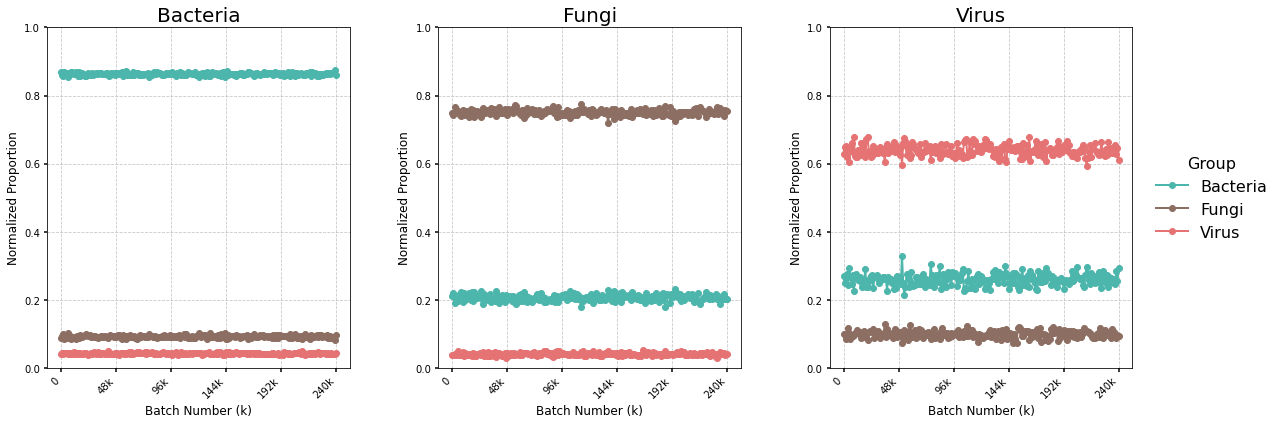

In [989]:
# Load df and indices
indices = np.load('new_indices_epoch0.npy')

# Sort df by indices
df_sorted = df.reindex(indices)

_, unique_sk, anchor_list,_ = count_unique_values_in_chunks(df_sorted, chunk_size=9)

batch_stats = process_superkingdom_batches(unique_sk, anchor_list)

fig = plot_superkingdom_distribution(batch_stats)

fig.savefig('figs/superkingdom_composition_resampled.svg', format='svg', bbox_inches='tight', dpi=300)

## Feature Importance

In [915]:
# Construct file paths
coefs_path = os.path.join('dbs', 'coefs.csv')
qr_path = os.path.join('dbs', 'quality_report.tsv')
virus_path = os.path.join('dbs', 'gtdbtk.ar53.summary.tsv')
bac_path = os.path.join('dbs', 'gtdbtk.bac120.summary.tsv')

# Read data files
coef_df = pd.read_csv(coefs_path)
qr = pd.read_csv(qr_path, sep='\t')
virus = pd.read_csv(virus_path, sep='\t')
bac = pd.read_csv(bac_path, sep='\t')

# Result dictionary
merged_results = {}

# Process each method
for method in ['logistic_l2']:
    # Filter data for the current method
    method_df = coef_df[coef_df['mil_method'] == method]

    # Merge with quality report
    method_df = method_df.merge(qr[['Name', 'Completeness', 'Contamination']], 
                    left_on='feature', right_on='Name', how='left')
        
    method_df = method_df[method_df['Completeness'] > 50]       

In [916]:
method_df

,mil_method,feature,fold,coef,Name,Completeness,Contamination
50,logistic_l2,65,1,7.766486e-07,65,99.45,118.06
51,logistic_l2,65,2,5.211583e-02,65,99.45,118.06
52,logistic_l2,65,3,3.296128e-01,65,99.45,118.06
53,logistic_l2,65,4,7.045349e-07,65,99.45,118.06
54,logistic_l2,65,5,1.329092e-06,65,99.45,118.06
...,...,...,...,...,...,...,...
78045,logistic_l2,1017,46,0.000000e+00,1017,55.69,0.19
78046,logistic_l2,1017,47,-9.229091e-06,1017,55.69,0.19
78047,logistic_l2,1017,48,-9.225201e-07,1017,55.69,0.19
78048,logistic_l2,1017,49,-9.169141e-02,1017,55.69,0.19


In [917]:
def analyze_and_merge_feature_importance(data_dir, mil_methods=['logistic_l1', 'logistic_l2', 'rf']):
    """
    Feature importance analysis and data merging function
    
    Parameters:
    -----------
    data_dir : str
        Directory path containing required data files
    mil_methods : list
        List of model methods to analyze (default: ['logistic_l1', 'logistic_l2', 'rf'])
    
    Returns:
    --------
    dict
        Dictionary containing merged DataFrames for each method
    """
    
    # Construct file paths
    coefs_path = os.path.join(data_dir, 'coefs.csv')
    qr_path = os.path.join(data_dir, 'quality_report.tsv')
    virus_path = os.path.join(data_dir, 'gtdbtk.ar53.summary.tsv')
    bac_path = os.path.join(data_dir, 'gtdbtk.bac120.summary.tsv')
    
    # Read data files
    coef_df = pd.read_csv(coefs_path)
    qr = pd.read_csv(qr_path, sep='\t')
    virus = pd.read_csv(virus_path, sep='\t')
    bac = pd.read_csv(bac_path, sep='\t')
    
    # Result dictionary
    merged_results = {}
    
    # Process each method
    for method in mil_methods:
        # Filter data for the current method
        method_df = coef_df[coef_df['mil_method'] == method]

        # Merge with quality report
        method_df = method_df.merge(qr[['Name', 'Completeness', 'Contamination']], 
                     left_on='feature', right_on='Name', how='left')
        
        method_df = method_df[method_df['Completeness'] > 50]
        #method_df = method_df[method_df['Contamination'] < 10]
        
        # Calculate mean absolute coefficients for each feature
        avg_coefs = method_df.groupby('feature')['coef'].mean().abs()
        coefs_df = method_df.groupby('feature')['coef'].mean().reset_index().rename(columns={'coef': 'mean_coef'})
        
        # Get top features and convert to DataFrame
        top_features = avg_coefs.nlargest(10)
        df = top_features.reset_index()
        
        # Merge with bacterial classification
        df = df.merge(bac[['user_genome', 'classification']], 
                     left_on='feature', right_on='user_genome', how='left')
        
        # Merge with quality report
        df = df.merge(qr[['Name', 'Completeness', 'Contamination']], 
                     left_on='feature', right_on='Name', how='left')
        
        # Clean up columns
        if 'user_genome' in df.columns:
            df = df.drop('user_genome', axis=1)
        
        # Merge with virus classification
        df = df.merge(virus[['user_genome', 'classification']], 
                     left_on='feature', right_on='user_genome', how='left')
        
        # Combine classifications
        df['classification'] = df['classification_x'].fillna(df['classification_y'])
        
        # Extract the last part of the classification
        df['species'] = df['classification'].apply(
            lambda x: x.split(';')[-1].split('__')[-1]
        )

        df['genus'] = df['classification'].apply(
            lambda x: x.split(';')[-2].split('__')[-1] if len(x.split(';')) >= 2 else x.split(';')[-1].split('__')[-1]
        )

        df['family'] = df['classification'].apply(
            lambda x: x.split(';')[-3].split('__')[-1] if len(x.split(';')) >= 3 else x.split(';')[-1].split('__')[-1]
        )

        df['order'] = df['classification'].apply(
            lambda x: x.split(';')[-4].split('__')[-1] if len(x.split(';')) >= 4 else x.split(';')[-1].split('__')[-1]
        )

        def get_classification(row):
            if row['species'] and len(row['species']) != 0:
                return row['species']
            elif row['genus'] and len(row['genus']) != 0:
                return 'Unclassified ' + row['genus']
            elif row['family'] and len(row['family']) != 0:
                return 'Unclassified ' + row['family']
            elif row['order'] and len(row['order']) != 0:
                return 'Unclassified ' + row['order']

        df['classification'] = df.apply(get_classification, axis=1)

        df = df.merge(coefs_df, left_on='feature', right_on='feature', how='left')
        
        # Select and reorder columns
        df = df[['feature', 'classification', 'species', 'genus', 'family', 'order', 'coef', 'mean_coef', 'Completeness', 'Contamination']]
        
        # Store in results
        merged_results[method] = df
    
    return merged_results

In [919]:
results_vamb = analyze_and_merge_feature_importance('vamb')
results_vamb['rf']

,feature,classification,species,genus,family,order,coef,mean_coef,Completeness,Contamination
0,12987,QAMH01 sp900544245,QAMH01 sp900544245,QAMH01,QAMH01,Coriobacteriales,0.006134,0.006134,53.03,9.39
1,1979,CAG-269 sp003525075,CAG-269 sp003525075,CAG-269,CAG-508,TANB77,0.005195,0.005195,100.00,89.49
2,1151,Faecousia sp000435995,Faecousia sp000435995,Faecousia,Oscillospiraceae,Oscillospirales,0.005130,0.005130,95.94,14.89
3,1579,Enterocloster clostridioformis,Enterocloster clostridioformis,Enterocloster,Lachnospiraceae,Lachnospirales,0.004831,0.004831,86.90,4.97
4,1582,CAG-170 sp000432135,CAG-170 sp000432135,CAG-170,Oscillospiraceae,Oscillospirales,0.004320,0.004320,96.89,102.87
5,1926,Eubacterium_F sp000433735,Eubacterium_F sp000433735,Eubacterium_F,Lachnospiraceae,Lachnospirales,0.003938,0.003938,82.48,18.75
6,15835,CAG-269 sp000437215,CAG-269 sp000437215,CAG-269,CAG-508,TANB77,0.003789,0.003789,53.78,6.35
7,83,Alistipes avistercoris,Alistipes avistercoris,Alistipes,Rikenellaceae,Bacteroidales,0.003596,0.003596,93.92,96.35
8,5762,CAG-103 sp900543625,CAG-103 sp900543625,CAG-103,Oscillospiraceae,Oscillospirales,0.003117,0.003117,89.19,46.95
9,255,Bacteroides cellulosilyticus,Bacteroides cellulosilyticus,Bacteroides,Bacteroidaceae,Bacteroidales,0.003086,0.003086,88.47,2.66


In [920]:
results_dbh = analyze_and_merge_feature_importance('dbh')
results_dbh['logistic_l1']

,feature,classification,species,genus,family,order,coef,mean_coef,Completeness,Contamination
0,64,UBA11524 sp000437595,UBA11524 sp000437595,UBA11524,Aristaeellaceae,Christensenellales,67.218083,67.218083,100.00,109.18
1,66,Hominenteromicrobium mulieris,Hominenteromicrobium mulieris,Hominenteromicrobium,Acutalibacteraceae,Oscillospirales,49.687417,-49.687417,71.51,56.01
2,172,Unclassified Prevotella,,Prevotella,Bacteroidaceae,Bacteroidales,49.515951,49.515951,74.40,98.89
3,73,Escherichia coli,Escherichia coli,Escherichia,Enterobacteriaceae,Enterobacterales,45.880493,-45.880493,53.18,54.39
4,98,Coprococcus aceti,Coprococcus aceti,Coprococcus,Lachnospiraceae,Lachnospirales,43.575902,43.575902,100.00,98.38
5,33,Unclassified Anaerostipes,,Anaerostipes,Lachnospiraceae,Lachnospirales,22.835624,22.835624,82.68,40.80
6,200,Porcipelethomonas sp900538575,Porcipelethomonas sp900538575,Porcipelethomonas,Ruminococcaceae,Oscillospirales,15.101235,-15.101235,53.76,86.16
7,312,Fusicatenibacter_A intestinipullorum,Fusicatenibacter_A intestinipullorum,Fusicatenibacter_A,Acidaminococcaceae,Acidaminococcales,12.236827,12.236827,77.21,47.64
8,30,Lachnospira eligens_A,Lachnospira eligens_A,Lachnospira,Lachnospiraceae,Lachnospirales,11.613207,11.613207,72.59,76.83
9,96,Ruminiclostridium_E siraeum,Ruminiclostridium_E siraeum,Ruminiclostridium_E,Ruminococcaceae,Oscillospirales,10.138623,-10.138623,58.56,45.01


In [918]:
results_dbs = analyze_and_merge_feature_importance('dbs')
results_dbs['logistic_l2']

,feature,classification,species,genus,family,order,coef,mean_coef,Completeness,Contamination
0,34,UBA11524 sp000437595,UBA11524 sp000437595,UBA11524,Aristaeellaceae,Christensenellales,5.469378,5.469378,100.00,112.23
1,96,Alistipes putredinis,Alistipes putredinis,Alistipes,Rikenellaceae,Bacteroidales,4.302430,-4.302430,87.28,84.55
2,68,Coprococcus aceti,Coprococcus aceti,Coprococcus,Lachnospiraceae,Lachnospirales,3.665106,3.665106,100.00,102.88
3,91,Unclassified Prevotella,,Prevotella,Bacteroidaceae,Bacteroidales,3.583323,3.583323,64.37,87.10
4,146,Phil1 sp001940855,Phil1 sp001940855,Phil1,CAG-138,Christensenellales,3.398877,-3.398877,52.90,25.78
5,193,Porcipelethomonas sp900538575,Porcipelethomonas sp900538575,Porcipelethomonas,Ruminococcaceae,Oscillospirales,3.320803,-3.320803,55.46,38.02
6,164,Fusicatenibacter_A intestinipullorum,Fusicatenibacter_A intestinipullorum,Fusicatenibacter_A,Acidaminococcaceae,Acidaminococcales,3.052457,3.052457,89.59,73.73
7,192,Paraprevotella clara,Paraprevotella clara,Paraprevotella,Bacteroidaceae,Bacteroidales,2.468694,2.468694,82.08,54.83
8,115,Ruminococcus_C sp000433635,Ruminococcus_C sp000433635,Ruminococcus_C,Ruminococcaceae,Oscillospirales,2.433677,-2.433677,72.12,82.40
9,93,PeH17 sp000435055,PeH17 sp000435055,PeH17,CAG-138,Christensenellales,2.149676,-2.149676,74.49,77.05


In [921]:
list(set(results_dbh['logistic_l1']['species'].unique()) & set(results_dbs['logistic_l2']['species'].unique()))

['',
 'Coprococcus aceti',
 'Fusicatenibacter_A intestinipullorum',
 'UBA11524 sp000437595',
 'Porcipelethomonas sp900538575']

In [922]:
list(set(results_dbh['logistic_l1']['species'].unique()) & set(results_vamb['logistic_l2']['species'].unique()))

['Porcipelethomonas sp900538575', 'Hominenteromicrobium mulieris']

In [923]:
list(set(results_dbh['rf']['species'].unique()) & set(results_vamb['rf']['species'].unique()))

['Alistipes avistercoris', 'CAG-170 sp000432135']

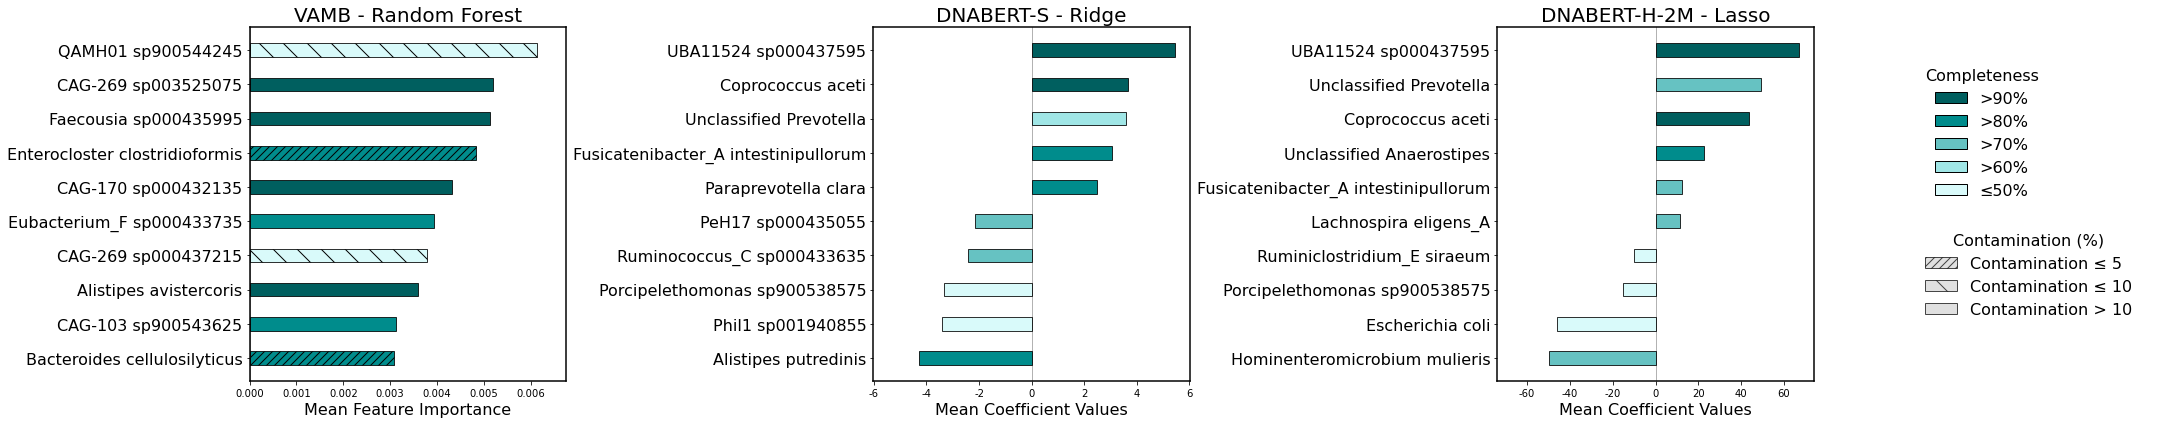

In [1000]:
def create_custom_feature_importance_subplots(results_vamb, results_dbh, results_dbs, subplot_configs, figsize=(40, 6)):
    """
    Create three subplots with specific parameter combinations for different datasets
    with shared color bar and contamination legend
    
    Parameters:
    -----------
    results_vamb : dict
        Results from VAMB analysis
    results_dbh : dict  
        Results from DNABERT-H analysis
    results_dbs : dict
        Results from DNABERT-S analysis
    figsize : tuple, optional
        Figure size (width, height)
    subplot_configs : list
        List of dictionaries containing configuration for each subplot
        Each dictionary should have the following keys:
        - 'data': pandas DataFrame containing the data
        - 'model_name': str, name of the model
        - 'score_name': str, name of the score
        - 'width_length': float, width of the score labels
    Returns:
    --------
    matplotlib.figure.Figure
        The created figure object
    """
    
    # Create figure with gridspec (1 row, 4 columns with specified width ratios)
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(1, 4, width_ratios=[1.35, 1.35, 1.35, 0.15])  # More space for legends
    
    
    # Define completeness thresholds and corresponding colors
    completeness_thresholds = [90, 80, 70, 60, 50]
    colors = ['#005f5f', '#008c8c', '#66c2c2', '#a0e6e6', '#d9fafa']
    
    # Create subplots
    axes = []
    for i, config in enumerate(subplot_configs):
        ax = fig.add_subplot(gs[0, i])
        axes.append(ax)
        
        df = config['data']
        df_sorted = df.sort_values(by='mean_coef', ascending=True)
        
        # Assign colors based on completeness thresholds
        bar_colors = []
        for idx, row in df_sorted.iterrows():
            completeness = row.get('Completeness', 0)
            if pd.isna(completeness):
                bar_colors.append(colors[-1])  # Use last color for NaN
            else:
                # Find the appropriate color based on thresholds
                for j, threshold in enumerate(completeness_thresholds[:-1]):
                    if completeness >= threshold:
                        bar_colors.append(colors[j])
                        break
                else:
                    bar_colors.append(colors[-1])
        
        # Create horizontal bar chart
        y_pos = np.arange(len(df_sorted))
        bars = ax.barh(y_pos, df_sorted['mean_coef'].values, height=0.4, color=bar_colors, 
                      edgecolor='black', linewidth=0.8)
        
        # Add vertical line at x=0 for reference
        ax.axvline(x=0, color='black', linestyle='-', alpha=0.3, linewidth=1)
        
        # Add hatches based on Contamination values
        if 'Contamination' in df_sorted.columns:
            for j, bar in enumerate(bars):
                contamination = df_sorted['Contamination'].iloc[j]
                
                if pd.isna(contamination):
                    hatch = ''
                elif contamination <= 5:
                    hatch = '///'
                elif contamination <= 10:
                    hatch = '\\'
                #elif contamination <= 20:
                #    hatch = '/'
                else:
                    hatch = ''
                
                bar.set_hatch(hatch)
        
        # Set y-ticks and labels
        ax.set_yticks(y_pos)
        
        # Set y-tick labels to classification names
        ax.set_yticklabels(df_sorted['classification'].values, fontsize=16)
        
        # Add value labels with appropriate formatting
        for x, bar in enumerate(bars):
            width = bar.get_width()
            # Position label to the right of positive bars and to the left of negative bars
            if width >= 0:
                ha_alignment = 'left'
                if config['score_name'] == 'Feature Importance':
                    x_position = width + 0.0002
                else:
                    x_position = width + config['width_length']
            else:
                ha_alignment = 'right'
                if config['score_name'] == 'Feature Importance':
                    x_position = width - 0.0002
                else:
                    x_position = width - config['width_length']
                
            if config['score_name'] == 'Feature Importance':
                label_text = f'{width:.4f}'
            else:
                label_text = f'{width:.0f}'
            
            #ax.text(x_position, bar.get_y() + bar.get_height()/2, 
            #         label_text, ha=ha_alignment, va='center', fontsize=10)
        
        # Set title (remove bold formatting)
        ax.set_title(config['model_name'], fontsize=20)
        
        # Add x-axis label to ALL subplots (not just middle one)
        ax.set_xlabel(f'Mean {config["score_name"]}', fontsize=16)
        
        # Find the maximum absolute coefficient value to set symmetric x-axis limits
        max_abs_coef = max(abs(df_sorted['mean_coef'].max()), abs(df_sorted['mean_coef'].min()))
        
        # Format x-axis to be centered at zero with symmetric limits
        x_limit = max_abs_coef * 1.1
        if not config['model_name'].endswith('Random Forest'):
            ax.set_xlim(-x_limit, x_limit)
        else:
            ax.set_xlim(0, x_limit)
        
        # Format x-axis based on score type
        if config['score_name'] == 'Feature Importance':
            ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.3f'))
        else:
            ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0f'))
            
        ax.tick_params(axis='x', which='major', labelsize=10)
        
        # Add border around each subplot
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(1.5)
            spine.set_color('black')
    
    # Create legends area in the fourth column
    legend_ax = fig.add_subplot(gs[0, 3])
    legend_ax.axis('off')
    
    # Create completeness legend
    completeness_labels = [f'>{threshold}%' for threshold in completeness_thresholds[:-1]] + ['≤50%']
    completeness_patches = [mpatches.Patch(facecolor=c, edgecolor='black', label=l) 
                           for c, l in zip(colors, completeness_labels)]
    
    # Position completeness legend in the legend area
    completeness_legend = legend_ax.legend(handles=completeness_patches, 
                                         loc='center left', 
                                         bbox_to_anchor=(-6, 0.7),
                                         fontsize=16, 
                                         frameon=False,
                                         title='Completeness',
                                         title_fontsize=16)
    
    # Add contamination legend with hatch patterns - positioned below completeness legend
    hatch_patterns = {
        'Contamination ≤ 5': '///',
        'Contamination ≤ 10': '\\',
    #    'Contamination ≤ 20': '/',
        'Contamination > 10': ''
    }
    
    contamination_patches = []
    for label, hatch in hatch_patterns.items():
        contamination_patches.append(mpatches.Patch(facecolor='lightgray', alpha=0.7, 
                                             hatch=hatch, label=label, edgecolor='black'))
    
    # Add second legend for contamination below the completeness legend
    legend_ax.legend(handles=contamination_patches, 
                    loc='center left', 
                    bbox_to_anchor=(-6, 0.3),  # Position below completeness legend
                    fontsize=16, 
                    frameon=False,
                    title='Contamination (%)',
                    title_fontsize=16)
    
    # Add the first legend back (it gets removed when adding the second legend)
    legend_ax.add_artist(completeness_legend)
    
    # Adjust layout to make room for legends
    plt.tight_layout()
    plt.subplots_adjust(wspace=1.25,right=0.75)  # Adjusted for better spacing
    
    return fig

subplot_configs = [
        {
            'data': results_vamb['rf'],
            'model_name': 'VAMB - Random Forest',
            'score_name': 'Feature Importance',
            'width_length': 0
        },
        {
            'data': results_dbs['logistic_l2'],
            'model_name': 'DNABERT-S - Ridge', 
            'score_name': 'Coefficient Values',
            'width_length': 0.06
        },
        {
            'data': results_dbh['logistic_l1'], 
            'model_name': 'DNABERT-H-2M - Lasso',
            'score_name': 'Coefficient Values',
            'width_length': 1
        }
    ]

# Create the subplots in the correct order matching your image
fig = create_custom_feature_importance_subplots(results_vamb, results_dbh, results_dbs, subplot_configs)

# Save and display
plt.savefig('figs/top10_fi_best.svg', dpi=300, bbox_inches='tight')
plt.show()

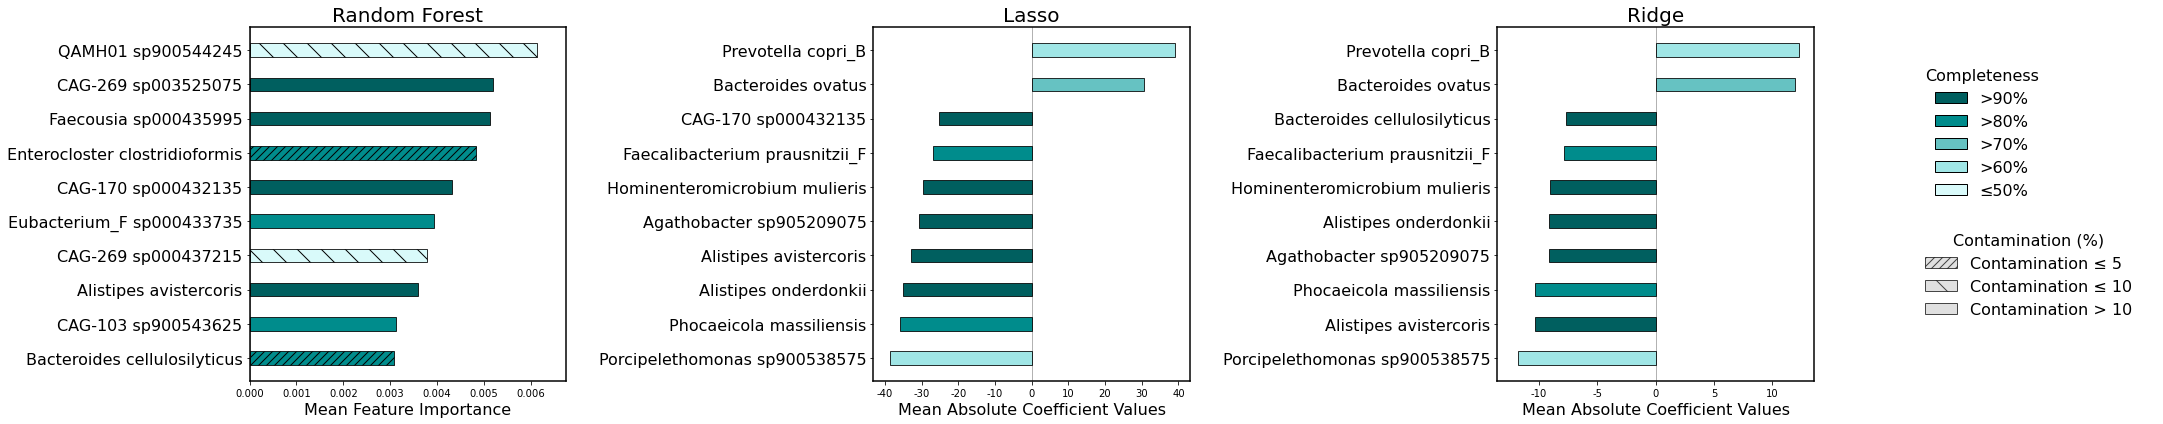

In [1001]:
subplot_configs = [
{
    'data': results_vamb['rf'],
    'model_name': 'Random Forest',
    'score_name': 'Feature Importance',
    'width_length': 0
},
{
    'data': results_vamb['logistic_l1'],
    'model_name': 'Lasso', 
    'score_name': 'Absolute Coefficient Values',
    'width_length': 0.6
},
{
    'data': results_vamb['logistic_l2'], 
    'model_name': 'Ridge',
    'score_name': 'Absolute Coefficient Values',
    'width_length': 0.2
}
]

# Create the subplots in the correct order matching your image
fig = create_custom_feature_importance_subplots(results_vamb, results_dbh, results_dbs, subplot_configs)

# Save and display
plt.savefig('figs/top10_fi_vamb.svg', dpi=300, bbox_inches='tight')
plt.show()

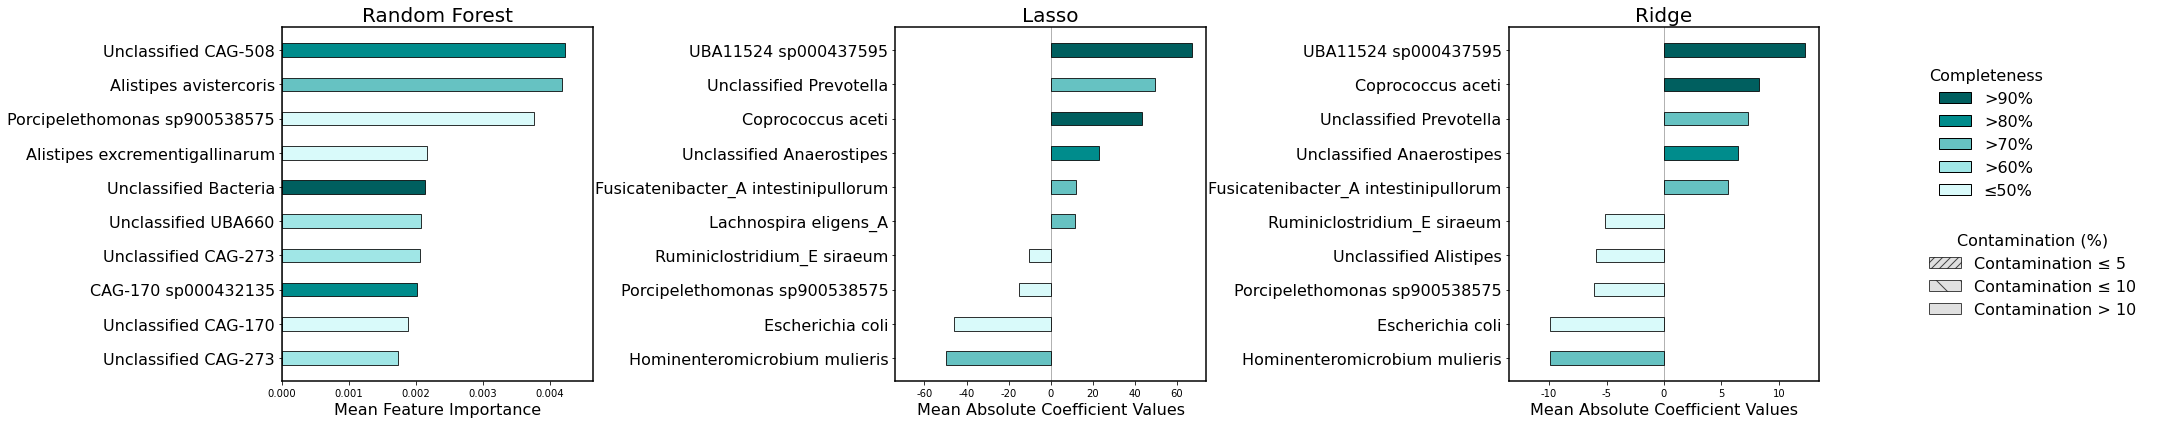

In [1002]:
subplot_configs = [
{
    'data': results_dbh['rf'],
    'model_name': 'Random Forest',
    'score_name': 'Feature Importance',
    'width_length': 0
},
{
    'data': results_dbh['logistic_l1'],
    'model_name': 'Lasso', 
    'score_name': 'Absolute Coefficient Values',
    'width_length': 0.6
},
{
    'data': results_dbh['logistic_l2'], 
    'model_name': 'Ridge',
    'score_name': 'Absolute Coefficient Values',
    'width_length': 0.2
}
]

# Create the subplots in the correct order matching your image
fig = create_custom_feature_importance_subplots(results_vamb, results_dbh, results_dbs, subplot_configs)

# Save and display
plt.savefig('figs/top10_fi_dbh.svg', dpi=300, bbox_inches='tight')
plt.show()

## t-SNE for WEGOVY Bags

In [609]:
sample_df = pd.read_csv('vamb/samples_filtered.csv')
cluster_df = pd.read_csv('vamb/cluster_abundances.tsv', sep='\t')
cluster_df = cluster_df.T
cluster_df = cluster_df.reset_index()
cluster_df = cluster_df.rename(columns={'index': 'sample_ID'})
cluster_df = cluster_df.iloc[1:]
cluster_df = cluster_df.reset_index(drop=True)

cluster_df['sample_ID'] = cluster_df['sample_ID'].str.split('.').str[0]
cluster_df = cluster_df.merge(sample_df[['sample_id', 'BMI_loss_percent', 'baseline_age', 'baseline_BMI', 'baseline_weight', 'dosage_cumulative']], left_on='sample_ID', right_on='sample_id', how='left')

cluster_df.loc[16, 'BMI_loss_percent'] = cluster_df.loc[40, 'BMI_loss_percent']
cluster_df.loc[16, 'baseline_age'] = cluster_df.loc[40, 'baseline_age']
cluster_df.loc[16, 'baseline_weight'] = cluster_df.loc[40, 'baseline_weight']

cluster_df.loc[18, 'baseline_age'] = 40
cluster_df.loc[41, 'baseline_age'] = 40

cluster_df.loc[:23, 'BMI_loss_percent'] = cluster_df.loc[24:, 'BMI_loss_percent'].values
cluster_df.loc[:23, 'dosage_cumulative'] = cluster_df.loc[24:, 'dosage_cumulative'].values

del cluster_df['sample_id']


/Users/eisukeokuda/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


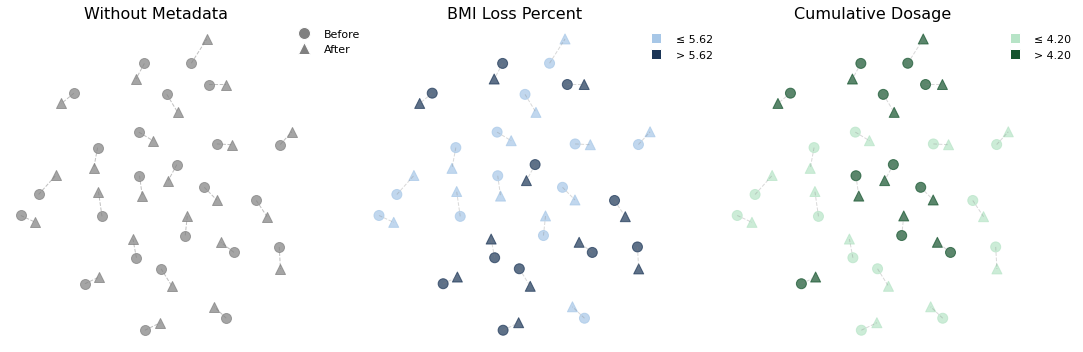

In [719]:
def create_tsne_subplots(cluster_df, metadata_columns, 
                        perplexity=17, n_iter=1000, connect_same_suffix=True,
                        color_below='#A7C7E7', color_above='#1B3556'):
    """
    Create a grid of t-SNE plots with one baseline plot and multiple metadata plots.
    
    Parameters:
    -----------
    cluster_df : pandas.DataFrame
        DataFrame with sample_ID column, cluster data columns (0-2612), and metadata columns
    metadata_columns : list
        List of column names for binary classification in additional plots
    perplexity : int, optional
        Perplexity parameter for t-SNE (default: 17)
    n_iter : int, optional
        Number of iterations for t-SNE (default: 1000)
    connect_same_suffix : bool, optional
        Whether to connect points with the same suffix (default: True)
    color_below : str, optional
        Color for values below threshold (default: 'blue')
    color_above : str, optional
        Color for values above threshold (default: 'red')
    
    Returns:
    --------
    matplotlib.figure.Figure
        The figure containing all subplots
    """
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from sklearn.manifold import TSNE
    from matplotlib.lines import Line2D
    import matplotlib.cm as cm
    import matplotlib.gridspec as gridspec
    
    # Calculate the number of rows needed
    num_plots = len(metadata_columns) + 1  # baseline + metadata plots
    
    # Create figure with GridSpec for 1 row, 4 columns
    fig = plt.figure(figsize=(15, 5))  
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1]) 
    
    # Perform t-SNE once to reuse for all plots
    X = cluster_df.iloc[:, 1:2614].values
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, random_state=42, init='random', metric='cosine')
    tsne_results = tsne.fit_transform(X)
    
    # Create a DataFrame with t-SNE results
    df_tsne = pd.DataFrame({'t-SNE 1': tsne_results[:, 0], 't-SNE 2': tsne_results[:, 1]})
    df_tsne['sample_ID'] = cluster_df['sample_ID'].values
    
    # Extract prefix (0_ or 1_) and suffix for grouping
    df_tsne['prefix'] = df_tsne['sample_ID'].apply(lambda x: x.split('_')[0] + '_')
    df_tsne['suffix'] = df_tsne['sample_ID'].apply(lambda x: '_'.join(x.split('_')[1:]))
    
    # Define markers for each prefix
    markers = {'0_': 'o', '1_': '^'}
    
    # Create a color map for unique suffixes (for baseline plot)
    unique_suffixes = df_tsne['suffix'].unique()
    color_map = cm.get_cmap('tab20')  # Use a colormap with many distinct colors
    suffix_colors = {suffix: color_map(i/len(unique_suffixes)) 
                     for i, suffix in enumerate(unique_suffixes)}
    
    # Create prefix legend elements (to be used in the rightmost subplot)
    prefix_legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Before', 
               markerfacecolor='gray', markersize=12),
        Line2D([0], [0], marker='^', color='w', label='After', 
               markerfacecolor='gray', markersize=12)
    ]
    
    # 1. First plot (Baseline - by suffix)
    ax1 = plt.subplot(gs[0, 0])
    
    # First, draw connection lines between points with same suffix
    if connect_same_suffix:
        for suffix in unique_suffixes:
            # Get all points with this suffix
            suffix_points = df_tsne[df_tsne['suffix'] == suffix]
            
            if len(suffix_points) >= 2:  # Only connect if there are at least 2 points
                # Get coordinates
                coords = suffix_points[['t-SNE 1', 't-SNE 2']].values
                
                # Use gray for connection
                line_color = 'gray'
                
                # If there are exactly 2 points, just connect them
                if len(suffix_points) == 2:
                    ax1.plot(
                        coords[:, 0], 
                        coords[:, 1], 
                        '--', 
                        color=line_color, 
                        alpha=0.5,
                        linewidth=1.0
                    )
    
    # Plot points for each prefix
    for prefix in ['0_', '1_']:
        prefix_points = df_tsne[df_tsne['prefix'] == prefix]
        
        ax1.scatter(
            prefix_points['t-SNE 1'],
            prefix_points['t-SNE 2'],
            marker=markers[prefix],
            c='gray',  # Use gray for baseline
            s=100,
            alpha=0.7
        )
    
    ax1.set_title('Without Metadata', fontsize=16)
    ax1.axis('off')
    
    # 2. Add metadata plots
    assert len(metadata_columns) == 2, "metadata_columns must contain 2 columns"

    for i, metadata_column in enumerate(metadata_columns):
        if i == 1:
            color_below = '#B7E4C7'
            color_above = '#14532D'
        ax = plt.subplot(gs[0, i+1])
        
        # Add metadata for coloring
        if metadata_column in cluster_df.columns:
            df_tsne[metadata_column] = cluster_df[metadata_column].values
            
            # Calculate threshold
            threshold = df_tsne[metadata_column].median()
            
            # Create binary classification based on threshold
            df_tsne['binary_class'] = (df_tsne[metadata_column] > threshold).astype(int)
            
            # First, draw connection lines between points with same suffix
            if connect_same_suffix:
                for suffix in unique_suffixes:
                    # Get all points with this suffix
                    suffix_points = df_tsne[df_tsne['suffix'] == suffix]
                    
                    if len(suffix_points) >= 2:  # Only connect if there are at least 2 points
                        # Get coordinates
                        coords = suffix_points[['t-SNE 1', 't-SNE 2']].values
                        
                        # Use gray for connection
                        line_color = 'gray'
                        
                        # If there are exactly 2 points, just connect them
                        if len(suffix_points) == 2:
                            ax.plot(
                                coords[:, 0], 
                                coords[:, 1], 
                                '--', 
                                color=line_color, 
                                alpha=0.3,
                                linewidth=1.0
                            )
            
            # Get points for each prefix
            one_prefix_points = df_tsne[df_tsne['prefix'] == '1_']
            zero_prefix_points = df_tsne[df_tsne['prefix'] == '0_']

            # Define colors based on binary classification
            one_prefix_colors = [color_above if binary_class == 1 else color_below for binary_class in one_prefix_points['binary_class']]
            zero_prefix_colors = [color_below if binary_class == 0 else color_above for binary_class in zero_prefix_points['binary_class']]
            
            # Plot points for each prefix
            ax.scatter(
                one_prefix_points['t-SNE 1'],
                one_prefix_points['t-SNE 2'],
                marker=markers['1_'],
                c=one_prefix_colors,
                s=100,
                alpha=0.7
            )
            
            ax.scatter(
                zero_prefix_points['t-SNE 1'],
                zero_prefix_points['t-SNE 2'],
                marker=markers['0_'],
                c=zero_prefix_colors,
                s=100,
                alpha=0.7
            )
            
            # Create threshold legend for this subplot
            threshold_legend_elements = [
                Line2D([0], [0], marker='s', color='w', label=f'≤ {threshold:.2f}',
                       markerfacecolor=color_below, markersize=10),
                Line2D([0], [0], marker='s', color='w', label=f'> {threshold:.2f}',
                       markerfacecolor=color_above, markersize=10)
            ]

            if metadata_column == 'BMI_loss_percent':
                title = 'BMI Loss Percent'
            elif metadata_column == 'dosage_cumulative':
                title = 'Cumulative Dosage'
            
            # Add metadata legend inside the plot
            ax.legend(handles=threshold_legend_elements, 
                      loc='upper right',  # 右下に配置
                      title_fontsize=11,
                      bbox_to_anchor=(1.2, 1), 
                      fontsize=11,
                      framealpha=0.7,
                      frameon=False)  # 半透明の背景
            
            ax.set_title(title, fontsize=16)
            ax.axis('off')
    
    ax_legend = plt.subplot(gs[0, 0])  # 最後の列
    ax_legend.axis('off')
    
    # Add prefix legend to the left side
    ax_legend.legend(handles=prefix_legend_elements, 
                   loc='upper right', 
                   title_fontsize=11,
                   bbox_to_anchor=(1.2, 1), 
                   fontsize=11,
                   borderaxespad=0.,
                   frameon=False)
    
    plt.tight_layout()
    return fig

metadata_columns = ['BMI_loss_percent', 'dosage_cumulative']

fig = create_tsne_subplots(
    cluster_df,
    metadata_columns=metadata_columns,
    perplexity=17
)

plt.savefig('figs/tsne_combined_subplots.svg', dpi=300, bbox_inches='tight')
plt.show()